# Lab 2: Root Finding

#### Objectives

The main objectives of this lab are as follows.

- Learn that solving numerical problems can require analytic work too! Computational techniques are an additional tool we use when solving problems, not a replacement for the analytic tools we already know.
- Study root finding using functions from `scipy.optimize`.
- Become more comfortable using the built-in documentation by always you looking up the documentation on new functions.

## Initialization

Put all the initialization in the cell below.  This should include loading `numpy` and setting up plotting (loading the module and running `%matplotlib inline`).  It should also include loading `scipy.optimize`.

###### Environment Initialization Code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.optimize as opt

## Problem Statement

Here we will solve the following problem.  Consider a water hose with initial water velocity, $v$, aimed at an angle, $\alpha$, with respect to the ground, targetting a fire a height, $h$, above the ground.  It can be shown that to hit the target the horizontal distance, $x$, between the nozzle and the fire satisfies the quadratic equation

$$ \frac{g}{2v^2\cos^2\alpha} x^2 - x \tan\alpha + h = 0. $$

Our goal is to find the optimal angle, $\alpha_O$, at which to aim the hose such that we hit the fire from the maximum distance away, $x_{\mathrm{max}}$.

Throughout this lab we will use $g=9.8\;\mathrm{m/s^2}$.

## Preliminaries

We have a problem and we are taking a course in computational physics so our first thought may be to start typing away hoping that the computer will produce answers.  However, here we will spend some time doing analytic work to

1. manipulate the system to answer specific questions,
2. turn these manipulations into a form the computer can handle,
3. calculate simple cases to test the numerical results.

To begin, the system described in the problem statement is a familiar one.  It really has nothing to do with the flow of water, and is a topic studied extensively in introductory physics. When solving numerical problems it is important to understand the physics of the system being studied; This allows us to use our intuition to determine whether results produced by our codes make sense or not.  Remember that a computer does what we tell it to do, which is often not what we want it to do!  Thus we need to break our analysis down into small, understandable steps and constantly ask whether or not the results at each step make sense.
What well known physics topic is this problem really about? This is nothing more than **projectile motion**!

## Test Case

As stated above, it is essential to have a test case (or preferably more than one) in mind whenever solving a problem. Though correctly solving a simple case is not a guarantee that your technique will work for more complicated case, at least it gives you some confidence. Here we will start with the case where the water trajectory starts and ends at the same height, $h=0$.  This is a problem you have probably solved before!

For $h=0$, state the optimal angle, $\alpha_O$, that leads to the maximum distance the water travels, $x_{\mathrm{max}}$.  Also calculate $x_{\mathrm{max}}$.  Specify your answers below.  (*Note:* As you have seen in notebooks, we can insert full documentation including nicely formatted equations using $\LaTeX$. You do not need to do so here; for now just make sure your answers can be clearly understood.) Use the cell below to provide an answer.

In solving the equation given above, and differentiating the equation with respect to the angle, we get tan(alpha) = 1, which gives us alpha = 45 deg. At this angle, x_max = v^2/g.

## Solving the Problem

We are now ready to think about the general problem.  We will begin by *analytically* solving the quadratic equation for $x(\alpha)$.

Analytically solve the quadratic equation, modified as discussed above, for $x(\alpha)$ and write it in a form that can be evaluated numerically.  Since we have yet to discuss how to typeset such equations, we will instead only define it as a function.  Define a function that given $\alpha$, $h$, and $v$, returns the solution.  Of course, since we are solving a quadratic equation we know there are two solutions.  To account for this, write a function based on the template
```
def xalpha(alpha, h, v, sgn=+1):
``` 

Here `sgn` refers to the "$\pm$" that appears in the solution to a quadratic equation.  By default we choose the "$+$" solution, but can get the "$-$" solution by passing in `-1`.

*Hint: 
Even this simple step can pose a problem: naively solving the quadratic equation would give us terms in the solution that include contributions proportional to $1/\cos^2\alpha$.  Numerically, why is having $\cos\alpha$ in the denominator a problem?  What would happen if we try to evaluate such a term for all values of the angle with $0\le\alpha\le\pi$?* Notice that $\cos(\pi/2)=0$, so $1/\cos(\pi/2)$ blows up.

*It is probably best to multiply the quadratic equation by $\cos^2\alpha$ and use that as our base equation.  In fact, we can go further than this.  It may be more elegant to rewrite the equation in terms of $\sin(2\alpha)$ and $\cos(2\alpha)$ using double angle formulas.  Or it may not!  How far we go in manipulating the equations analytically is up to us.*

In [2]:
def xalpha(alpha, h, v, sgn=+1) :
    """Distance as a function of angle, alpha, to hit a target at height h.
    alpha : angle expressed in degrees,
    h : height of target in meters,
    v : speed of water in m/s,
    sgn : +1 or -1, determines which solution of the quadratic equation to calculate.
    """
    g = 9.8
    rad = np.pi*alpha/180.
    term1 = v**2./(2.*g)*np.sin(2.*rad)
    term2 = v**2./g*np.sqrt(np.sin(2.*rad)**2/4.-2.*g/v**2*h*np.cos(rad)**2)
    
    if sgn == -1:
        term2 = -1.*term2
    return term1 + term2

To test your function, print the two solutions for $h=0$ along with the expected results.  These should agree!  If they don't, you will need to go back and figure out why not! (*Hint: you were not told $v$, why not?  What should you do in this case?*)

In [5]:
print(f'function: {xalpha(45, 0, 5, sgn=1)}')
print(f'analytical: {5**2/9.8}')
print(f'function: {xalpha(45, 0, 5, sgn=-1)}')
print(f'analytical: {0.}')

function: 2.5510204081632653
analytical: 2.5510204081632653
function: 0.0
analytical: 0.0


Finally, we want to find the optimal angle. We can do this (at least) two ways: finding a function maximum, or finding an extremum by computing a zero of the function derivative. Here we will do so both ways.

### 1) Optimization by finding the root

We know that we can find extrema using derivatives.  In particular here we wish to find $\alpha_O$ such that
$$ \left. \frac{\mathrm{d}x}{\mathrm{d}\alpha} \right|_{\alpha=\alpha_O} = 0. $$

Since we just solved for $x(\alpha)$ our first thought might be take the derivative of it with respect to $\alpha$. An easy way to do this is to *implicitly differentiate* the original quadratic equation, using the fact that the derivative of $x$ with respect to $\alpha$ when evaluated at $\alpha_O$ is zero.

Calculate an equation of the form $f(\alpha_O)=0$ that can be solved to find the optimal angle $\alpha_O$.  Define the function $f(\alpha_O)$ of the form
```
def deriv_alpha(alpha, h, v, sgn=+1) :
```
similar to `xalpha` defined above.  Make sure you write it in a form that works for all allowed values of `alpha`.
Finally, do not forget to document your function.

In [14]:
def deriv_alpha(alpha, h, v, sgn=+1):
    """Derivative of x with respect to alpha.
    Inputs:
    alpha: degrees
    h: height
    v: velocity
    sgn: sgn=+1 by default
    """
    g = 9.8
    rad = np.pi*alpha/180.
    return np.sin(rad)**2-0.5/(1-g*h/v**2)

In [16]:
deriv_alpha?

Verify your function works by numerically finding the optimal angle when $h=0$. Recall that the `opt.brentq` function allows us to supply arguments to the function we are trying to minimize using the `args` keyword argument.

Print your result along with the expected one.  Again, these **must agree**.

In [15]:
opt.brentq(deriv_alpha, 0, 90, args=(0, 5))

45.0

### Another Application

Now that we have code that works for a known case, let us apply it to another case.  Suppose we wish to put out a fire a height $13.5\;\mathrm{m}$ above a nozzle that outputs water with a speed of $20\;\mathrm{m/s}$.  Let us first see what $x(\alpha)$ looks like in this case.  Produce a quick plot of $x(\alpha)$ for $0\le\alpha\le 180$ in degrees, including solutions for both signs.

/Users/moseschung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
/Users/moseschung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


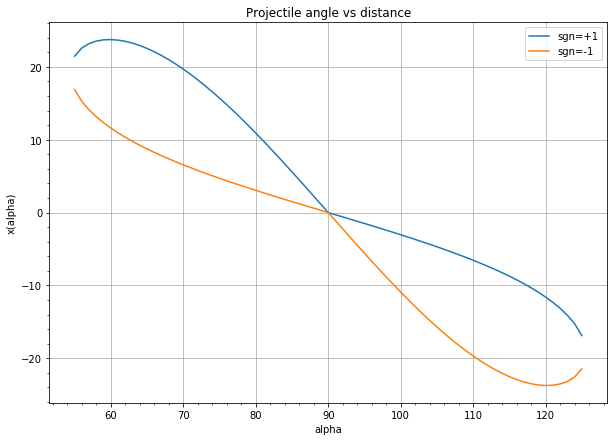

In [8]:
alpha = np.linspace(0, 180, 181)
h = 13.5
v = 20
plt.figure(figsize=(10,7))
plt.plot(alpha, xalpha(alpha, h, v), label='sgn=+1')
plt.plot(alpha, xalpha(alpha, h, v, sgn=-1), label='sgn=-1')
plt.legend()
plt.ylabel('x(alpha)')
plt.xlabel('alpha')
plt.title('Projectile angle vs distance')
plt.grid()
plt.minorticks_on()

This was a nice idea, but now we need to understand what just happened.  Firstly, you probably received a warning message before the plot was created.  Secondly, the plot does not run over the full range of angles we specified.  Thirdly, there are negative distances!

Assuming there was one, think about the source of the warning message (just because it is only a warning that does not mean we can ignore it), why the plot does not extend over the full range of angles, and why the distance changes sign when $\alpha>90^\circ$.  Finally, which solution produces the maximum distance over the angles of interest, when `sgn=+1` or when `sgn=-1`?

The error is with regard to the square root: when it is negative we do not have a valid solution.  Physically this is just the statement that if we do not aim the water with a large enough angle, then we cannot reach the desired height, $h$.  In other words, there *should* be a minimum angle!  Clearly if $\alpha=0$ we can never reach a height $h>0$.  Similarly, if $\alpha>90^\circ$, then we have aimed the nozzle "backwards", which corresponds to the negative $x$-direction.  Thus it is not surprising that distance becomes negative.  Finally, the maximum distance occurs for the blue curve in the figure, which is the case of `sgn=+1`.

Calculate and print the minimum angle $\alpha_{\mathrm{min}}$.  Also store this value as we will use it later.  (Recall that we prefer to see angles in degrees, but the computer does not.  We should always print values in human readable forms and should always print out units.)

In [9]:
g = 9.8
alpha_min = np.arcsin(np.sqrt(2.*g/v**2*h))*180./np.pi
print(f'alpha_min is {alpha_min} deg')

alpha_min is 54.42222477035235 deg


**Finally** calculate the optimal angle, $\alpha_O$.  Print this angle and the value of the maximum distance.  Once again, save this angle as we will need it again. (Once again we should print the angle in degrees and include units on all output values.)

In [10]:
alpha_o = opt.brentq(deriv_alpha, 0, 90, args=(h, v))
print(f'alpha_o is {alpha_o} deg')
print(f'maximum distance is {xalpha(alpha_o, h, v)} m')

alpha_o is 59.80883307052552 deg
maximum distance is 23.74724605353282 m


### 2) Optimization by finding the maximum

In order to find the maximum, we could alternatively have called `opt.minimize_scalar`. While this function is useful for one-dimensional *minimization*, we need to find the maximum. First, create a function you can minimize, or that returns $-x(\alpha)$.

*Note: there is also an `opt.minimize` function that can be used to similar effect, and is useful for multimensional minimization. You are welcome to use that function, and encouraged to read the documentation, but `minimize_scalar` will be sufficient for our needs.*

In [11]:
def neg_xalpha(alpha, h, v, sgn=+1) :
    """Minus the distance as a function of angle, alpha, to hit a target at height h.
    alpha : angle expressed in degrees,
    h : height of target in meters,
    v : speed of water in m/s,
    sgn : +1 or -1, determines which solution of the quadratic equation to calculate.
    """
    return -xalpha(alpha, h, v, sgn)

Looking at the documentation for `opt.minimize_scalar`, we see that the default method is the Brent method. As discussed in class, this method requires three points in order to "bracket" a minimum. Although the bracket argument is optional, and excluding it will sometimes work, in our case we will need to specify a bracket. You can identify three such points from the plot of $x(\alpha)$ above, and supply these three points as a *tuple*, `bracket=(a, b, c)`.

Below, find the optimal angle $\alpha_O$ by directly minimizing `neg_xalpha`. The `opt.minimize_scalar` function returns an object, including the relevant maximum you need, along with information regarding the number of function calls and iterations. You are encouraged to explore how this maximization procedure compares to root finding, but the result you get for $\alpha_O$ **must agree** with the result you obtained from fiding the root above.

In [12]:
brent_alpha_o = opt.minimize_scalar(neg_xalpha, args=(h, v), bracket=(55, 60, 70))
print(f'alpha_o from Brent\'s method gives {brent_alpha_o.x} deg')

alpha_o from Brent's method gives 59.808832922029964 deg


## Plot

To confirm our results we can create another plot. For this we will build upon suggestions from earlier assignments, along with some new suggestions. There are, of course, exceptions to these suggestions but in general they should be followed:

1. Each line in a figure should be distinct and easily recognizable. When you look at the documentation, the most basic way of calling plot that allows changes is to include a format specifier.  For example `plot(x, y, ‘k-’)` will plot a solid, black line. For plots viewed online, using different colors is often sufficient, though will be less useful for color blind readers.  If the plot will appear in print, it will often appear in black and white, so it is best to use different line styles in addition to changing color.
2. Each line in a figure should be labeled.  This can be done using the `label` keyword.  It should provide a short description of what the line represents.  The label is used to create a legend in the figure.  This can be included by using the `legend` function.
3. All figures must include labels on the axes and a title.  Any figure that is not just a "quick plot" should have these!
4. There are many other things that can be done to polish figures.  One suggestion is using `minorticks_on`; another minor polishing involves changing the default line thickness using the `linewidth` or `lw` keyword to `plot`.

With this advice in mind create a single plot containing both solutions of $x(\alpha)$ for $\alpha_{\mathrm{min}}\le\alpha\le 90^\circ$.  In this plot include a vertical line at $\alpha_O$ and a horizontal line at $x(\alpha_O)$.

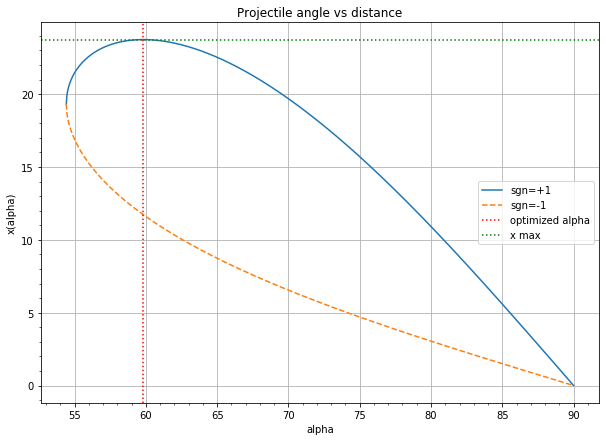

In [13]:
alpha = np.linspace(alpha_min, 90, 1000)
plt.figure(figsize=(10,7))
plt.plot(alpha, xalpha(alpha, h, v), label='sgn=+1')
plt.plot(alpha, xalpha(alpha, h, v, sgn=-1), ls='--', label='sgn=-1')
plt.axvline(alpha_o, label='optimized alpha', c='red', ls=':')
plt.axhline(xalpha(alpha_o, h, v), label='x max', c='green', ls=':')
plt.legend()
plt.ylabel('x(alpha)')
plt.xlabel('alpha')
plt.title('Projectile angle vs distance')
plt.grid()
plt.minorticks_on()

## Member Participation

See Lab 1 for instructions on turning in labs - we will follow this procedure the entire semester. In the following cell enter the names for each student in the group who partcipated in this lab.

Ahlers, Chung, Villegas